In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
%matplotlib inline

# Import custom modules
from lib.FramesDataset import FramesDataset
from lib import network

# Global variables
WARMUP = 20
T_STEPS = 5
FRAME_SIZE = 20

# Set device to use on network
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", DEVICE)

# Load previously trained model (2000 epochs)
model = network.RNN.load(
    hidden_units = 400,
    frame_size = FRAME_SIZE,
    t_steps = T_STEPS,
    path = './models/model-2000epochs-20210206-080756.pt'
)

Using cpu


In [ ]:
# Load dataset
train_dataset = FramesDataset('./datasets/processed_dataset_small.pkl', 'train', WARMUP)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
print("Training dataset length:", len(train_dataset))

## Spike triggered averaging

### Currently:
  1. Generate image of random Gaussian noise (mean 0, std 1)
  2. Feed noise into recurrent cell (initialised with activations of 0)
  3. Let recurrent cell run for same number of t_steps as during forward pass (but without 'warmup')
  4. Append generated noise to array if recurrent neuron has activation > threshold
  5. Average all noise frames that generated a response for each neuron

### Questions:
  1. Does it need warmup? I.e., should it match forward pass procedure?
  2. How should warmup data be generated? 20 noise frames that are the same or different?

Trial 0 x 10e3
Trial 1 x 10e3
Trial 2 x 10e3
Trial 3 x 10e3
Trial 4 x 10e3
Trial 5 x 10e3
Trial 6 x 10e3
Trial 7 x 10e3
Trial 8 x 10e3
Trial 9 x 10e3


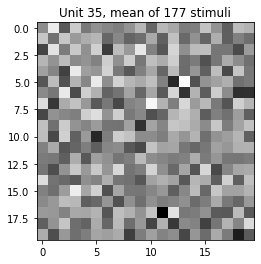

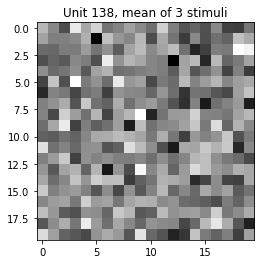

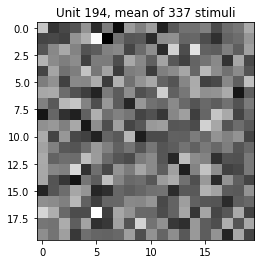

In [54]:
hidden_units = 400
activation_threshold = 15

stimuli = {}
for i in range(hidden_units):
    stimuli[i] = []

for t in range(10000):
    if t % 1000 == 0:
        print('Trial %i x 10e3' % (t/1e3))
    
    noise = np.random.normal(loc = 0, scale = 1, size=(FRAME_SIZE**2))
    noise = torch.Tensor(noise).unsqueeze(0).to(DEVICE)
    
    input = noise
    hidden_state = torch.zeros((1, hidden_units)).to(DEVICE)
    
    for t in range(T_STEPS):
        hidden_state = model.rnn(input, hidden_state)
        input = model.fc(hidden_state)

    units = hidden_state[0, :]
    for i, unit in enumerate(units):
        if unit > activation_threshold:
            stimuli[i].append(noise.squeeze(0).cpu().detach().numpy())

averaged_stimuli = {}
for i in range(hidden_units):
    stimuli_len = len(stimuli[i])
    if stimuli_len:
        averaged_stimuli[i] = np.stack(stimuli[i])
        averaged_stimuli[i] = np.reshape(np.mean(stimuli[i], 0), (FRAME_SIZE, FRAME_SIZE))
        plt.imshow(averaged_stimuli[i], cmap='gray')
        plt.title('Unit %i, mean of %i stimuli' % (i, stimuli_len))
        plt.show()

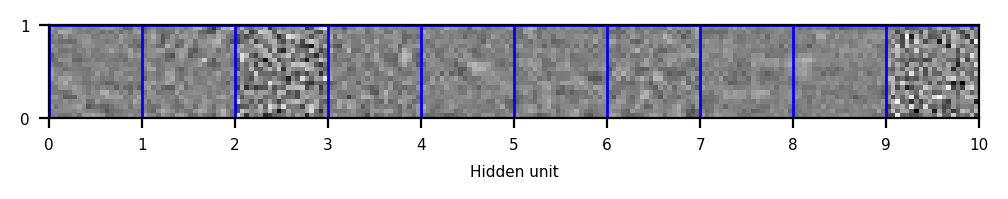

In [42]:
# Plot weights of input to recurrent layer
def plot_input_weights (model, hidden_units, frame_size):
    weights = model.rnn.weight_ih.cpu().detach().numpy()    
    weights = weights[:hidden_units, :]
    
    im = np.zeros((frame_size, frame_size*hidden_units))
    for i in range(hidden_units):
        hidden_unit_weights = weights[i]
        im[:, i*frame_size:(i+1)*frame_size] = np.reshape(hidden_unit_weights, (frame_size, frame_size))
    
    font_size = 5.5
    font_size_title = 6
    
    fig, ax = plt.subplots(dpi=200)
    ax.imshow(im, extent=[0, hidden_units, 0, 1], cmap='gray')
    
    ax.set_xticks(np.arange(0, hidden_units+1))
    ax.set_xticklabels(np.arange(0, hidden_units+1), size=font_size)
    ax.set_xlabel('Hidden unit', size=font_size)
    
    ax.set_yticks(np.arange(0, 2))
    ax.set_yticklabels(np.arange(0, 2), size=font_size)    
    
    ax.grid(which='major', color='b', linestyle='-', linewidth=1)
    
plot_input_weights(model, hidden_units = 10, frame_size = FRAME_SIZE)

In [ ]:
# Visualise network predictions
x, y = train_dataset[0]
x = x.to(DEVICE)
y = y.to(DEVICE)
pred = torch.squeeze(model(torch.unsqueeze(x, 0)), 0)

fig, axes = plt.subplots(1, T_STEPS+1, dpi=150)
for i in range(T_STEPS+1):
    im_y = y[i].view(20, 20).detach().cpu().numpy()
    axes[i].imshow(im_y, cmap='gray')
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(1, T_STEPS+1, dpi=150)
for i in range(T_STEPS+1):
    im_pred = pred[i].view(20, 20).detach().cpu().numpy()
    axes[i].imshow(im_pred, cmap='gray')
    axes[i].axis('off')
plt.show()